# Setup environment

In [1]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/'Colab Notebooks'/

/content/drive/MyDrive/Colab Notebooks


In [3]:
from utility import getComments, getReviewFinal

In [4]:
%cd Thesis/PeerRead/code/accept_classify/

/content/drive/My Drive/Colab Notebooks/Thesis/PeerRead/code/accept_classify


# Get Data and Target

In [5]:
r_train_path = "../../data/iclr_2017/train/reviews/"
train_files  = list(map(lambda f: r_train_path+f, os.listdir(r_train_path)))

train_data   = []
train_target = []
for name in tqdm(train_files):
   if getComments(name):
     train_data.append(getComments(name))
     train_target.append(getReviewFinal(name))     

r_valid_path = "../../data/iclr_2017/dev/reviews/"
valid_files  = list(map(lambda f: r_valid_path+f, os.listdir(r_valid_path)))

val_data   = []
val_target = []
for name in tqdm(valid_files):
   if getComments(name):
     val_data.append(getComments(name))
     val_target.append(getReviewFinal(name))     

r_test_path = "../../data/iclr_2017/test/reviews/"
test_files  = list(map(lambda f: r_test_path+f, os.listdir(r_test_path)))

test_data   = []
test_target = []
for name in tqdm(test_files):
   if getComments(name):
     test_data.append(getComments(name))
     test_target.append(getReviewFinal(name))     

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

# BERT

In [6]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.0 MB/s 
     |████████████████████████████████| 3.3 MB 54.4 MB/s 
     |████████████████████████████████| 895 kB 59.9 MB/s 
     |████████████████████████████████| 636 kB 72.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
import os, re, random, time, pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_curve, auc

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Utility Functions

In [18]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocessing_for_bert(data,max_len=128):
  input_ids = []
  attention_masks = []
  for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  
            add_special_tokens=True,        
            max_length=max_len,                  
            pad_to_max_length=True,        
            #return_tensors='pt',           
            return_attention_mask=True      
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
   
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

def evaluate_roc(probs, y_true,plot=False):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    if plot:
      plt.title('Receiver Operating Characteristic')
      plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
      plt.legend(loc = 'lower right')
      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')
      plt.show()
    return {'roc_auc': roc_auc,'accuracy': accuracy, 'probs': probs, 'fpr':fpr, 'tpr': tpr}      

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)    

In [9]:
# Concatenate train data and val data
all_data = np.concatenate([test_data, val_data])

# Encode our concatenated data
encoded_data = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (764 > 512). Running this sequence through the model will result in indexing errors


Max length:  2525


## BERT function and class definitions

In [19]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

# Create the BertClassfier class
class BertClassifier(nn.Module):
  
    def __init__(self, freeze_bert=False):
      
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

def initialize_model(dataloader, epochs=4,l_rate=5e-5):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=l_rate,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler        



def train(model,optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    # print("Start training...\n")
    AVG_LOSS = []
    VAL_LOSS = []
    VAL_ACC  = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        # print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        # print("-"*70)

        # Measure the elapsed time of each epoch
  
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                # print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        AVG_LOSS.append(avg_train_loss)
        # print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            VAL_LOSS.append(val_loss)
            VAL_ACC.append(val_accuracy)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
        #     print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        #     print("-"*70)
        # print("\n")
    
    # print("Training complete!")
    return {'loss': AVG_LOSS, 'val_loss':VAL_LOSS, 'val_acc':VAL_ACC}


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy  


def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs      

## Preparation

In [20]:
MAX_LEN    = 128 #@param

In [21]:
# Run function `preprocessing_for_bert` on the train set, the validation set, the test set
train_inputs, train_masks = preprocessing_for_bert(train_data, MAX_LEN)
val_inputs, val_masks     = preprocessing_for_bert(val_data, MAX_LEN)
test_inputs, test_masks   = preprocessing_for_bert(test_data, MAX_LEN)

# Labels to long()
train_labels = torch.Tensor(train_target).long()
val_labels   = torch.Tensor(val_target).long()

# Create the DataLoader for our training set
train_data    = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)

# Create the DataLoader for our validation set
val_data    = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)

# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Running First Time

In [ ]:
# batch_size = 16 #@param
# n_epoch    = 4 #@param
# lR         = 1.0e-5 #@param

In [22]:
def run_all(batch_size, n_epoch, lR, seed=42, find_params=False, getLoss=False): 
  # Data Loaders
  train_dataloader      = DataLoader(train_data     , sampler=train_sampler     , batch_size=batch_size)
  val_dataloader        = DataLoader(val_data       , sampler=val_sampler       , batch_size=batch_size)
  test_dataloader       = DataLoader(test_data      , sampler=test_sampler      , batch_size=batch_size)
  full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=batch_size)

  set_seed(seed)  # Set seed for reproducibility

  if find_params:
    bert_classifier, optimizer, scheduler = initialize_model(train_dataloader, epochs=n_epoch,l_rate=lR)
    train_Res = train(bert_classifier,optimizer, scheduler, train_dataloader, val_dataloader, epochs=n_epoch, evaluation=True)
    probs = bert_predict(bert_classifier, val_dataloader) # Compute predicted probabilities on the test set
    results = evaluate_roc(probs, val_target)     # Evaluate the Bert classifier
  else:
    bert_classifier, optimizer, scheduler = initialize_model(full_train_dataloader, epochs=n_epoch,l_rate=lR)
    train_Res = train(bert_classifier,optimizer, scheduler, full_train_dataloader, epochs=n_epoch)     # Train the Bert Classifier on the entire training data
    probs = bert_predict(bert_classifier, test_dataloader)     # Compute predicted probabilities on the test set
    results = evaluate_roc(probs, test_target)    # Evaluate the Bert classifier
  if getLoss:
    return results,train_Res
  else:
    return results

## Find Parameters

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
LRs    = np.array([5.e-07, 1.e-06, 5.e-06, 1.e-05, 5.e-05, 1.e-04])
nBatch = 16
nEpoch = 4
logs       = []
quick_logs = []
for lR in tqdm(LRs,leave=False,desc='lr'):
  for iSeed in tqdm(range(10), leave=False, desc='seed'):
    results = run_all(batch_size = nBatch, n_epoch=nEpoch, lR=lR, seed=iSeed, find_params=True)
    logs.append([lR, iSeed, results])
    quick_logs.append([lR, iSeed, results['roc_auc'], results['accuracy']])

with open(f'../../my_data/02-Review-Acceptance/bert_logs-{nBatch}', 'wb') as f:
  pickle.dump(logs, f)  
  
with open(f'../../my_data/02-Review-Acceptance/bert_quick_logs-{nBatch}', 'wb') as f:
  pickle.dump(quick_logs, f) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 

In [ ]:
# with open(f'../../my_data/02-Review-Acceptance/bert_logs-{nBatch}', "rb") as f:
#   load_logs=pickle.load(f)
# with open(f'../../my_data/02-Review-Acceptance/bert_quick_logs-{nBatch}', "rb") as f:
#   load_quick_logs=pickle.load(f)   

## Plotting

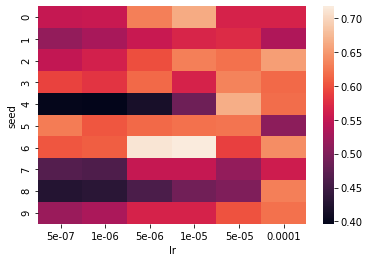

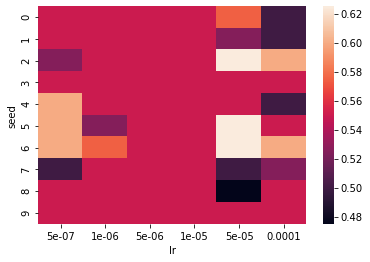

In [ ]:
df=pd.DataFrame(quick_logs,columns=['lr', 'seed','auc','accuracy'])
df1 = df.pivot("seed", "lr", "auc")
df2 = df.pivot("seed", "lr", "accuracy")

ax = sns.heatmap(df1)
plt.figure()
ax = sns.heatmap(df2)

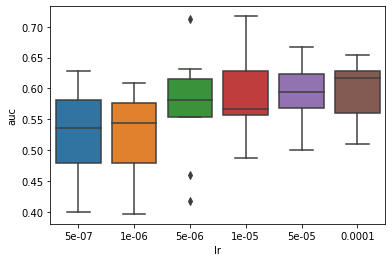

In [ ]:
sns.boxplot(data=df,x='lr',y='auc')

In [ ]:
# add a new column: average of auc and accuracy
df['avg'] = df.apply(lambda row: (row['auc']+row['accuracy'])/2, axis=1)
df.head(10)

,lr,seed,auc,accuracy,avg
0,5.000000e-07,0,0.553030,0.550,0.551515
1,5.000000e-07,1,0.515152,0.550,0.532576
2,5.000000e-07,2,0.550505,0.525,0.537753
3,5.000000e-07,3,0.590909,0.550,0.570455
4,5.000000e-07,4,0.398990,0.600,0.499495
5,5.000000e-07,5,0.628788,0.600,0.614394
6,5.000000e-07,6,0.603535,0.600,0.601768
7,5.000000e-07,7,0.467172,0.500,0.483586
8,5.000000e-07,8,0.426768,0.550,0.488384
9,5.000000e-07,9,0.520202,0.550,0.535101


In [ ]:
df.groupby('lr').mean()

,seed,auc,accuracy,avg
lr,,,,
5.000000e-07,4.5,0.525505,0.5575,0.541503
1.000000e-06,4.5,0.526515,0.5500,0.538258
5.000000e-06,4.5,0.572475,0.5500,0.561237
1.000000e-05,4.5,0.586364,0.5500,0.568182
5.000000e-05,4.5,0.588889,0.5600,0.574444
1.000000e-04,4.5,0.595202,0.5425,0.568851


In [ ]:
# with open('../../my_data/02-Review-Acceptance/bert_quick_logs-32', "rb") as f:
#   log_32=pickle.load(f)  
# df_32=pd.DataFrame(log_32,columns=['lr', 'seed','auc','accuracy'])
# df_32['avg'] = df_32.apply(lambda row: (row['auc']+row['accuracy'])/2, axis=1)
# df_32.to_pickle('../../my_data/02-Review-Acceptance/bert_dataframe-32')

with open('../../my_data/02-Review-Acceptance/bert_quick_logs-16', "rb") as f:
   log_16=pickle.load(f)  
df_16=pd.DataFrame(log_16,columns=['lr', 'seed','auc','accuracy'])
df_16['avg'] = df_16.apply(lambda row: (row['auc']+row['accuracy'])/2, axis=1)
df_16.to_pickle('../../my_data/02-Review-Acceptance/bert_dataframe-16')

In [ ]:
df_16.groupby('lr').mean().sort_values('avg',ascending=False)

,seed,auc,accuracy,avg
lr,,,,
5.000000e-05,4.5,0.588889,0.5600,0.574444
1.000000e-04,4.5,0.595202,0.5425,0.568851
1.000000e-05,4.5,0.586364,0.5500,0.568182
5.000000e-06,4.5,0.572475,0.5500,0.561237
5.000000e-07,4.5,0.525505,0.5575,0.541503
1.000000e-06,4.5,0.526515,0.5500,0.538258


## Test Results

In [ ]:
nBatch = 16
nEpoch = 4
best_lR = 5e-05
outcome       = []
quick_outcome = []
for iSeed in tqdm(range(10), leave=False, desc='seed'):
    results = run_all(batch_size = nBatch, n_epoch=nEpoch, lR=best_lR, seed=iSeed, find_params=False)
    outcome.append(results)
    quick_outcome.append([results['roc_auc'], results['accuracy']])


with open(f'../../my_data/02-Review-Acceptance/bert_outcome-{nBatch}', 'wb') as f:
  pickle.dump(outcome, f)  
  
with open(f'../../my_data/02-Review-Acceptance/bert_quick_outcome-{nBatch}', 'wb') as f:
  pickle.dump(quick_outcome, f) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transfo

In [ ]:
np.mean(quick_outcome,axis=0)

array([0.58      , 0.60263158])

# Additional Analsis

In [23]:
path = '../../my_data/Figures/02-Review-Acceptance-'

In [24]:
results,train_res = run_all(batch_size = 16, n_epoch=12, lR=5e-05, seed=0, find_params=True, getLoss=True)

# with open(f'../../my_data/01-Paper-Accept/bert_train_results-{nBatch}', 'wb') as f:
#   pickle.dump(train_res, f) 

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


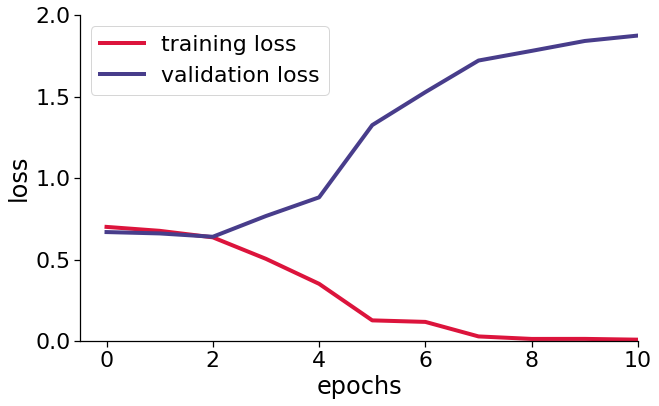

In [26]:
sns.set_context("notebook", font_scale=2)
fig,ax=plt.subplots(figsize = (10,6))

ax.plot(train_res['loss'],label='training loss', color='crimson', lw=4)
ax.plot(train_res['val_loss'],label='validation loss', color='darkslateblue', lw=4)
plt.xlim(-0.5,10)
plt.ylim(0,2)
plt.xlabel('epochs')
plt.ylabel('loss')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.rc({'font.size': 10})

ax.legend()

plt.savefig(path+'bert_epoch',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )
